# Finding Donors For *CharityML*

---

## Introduction

In this project, we will employ several supervised algorithms to accurately model individual's income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than USD 50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). It was donated by Ron Kohavi and Barry Becker, after being published in the article *"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"*, and we can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consist of small changes to the original dataset, such as removing the `'fnlwgt'` feature and record with missing or ill-formatted entries.

As a technical requisite, we are going first to load the libraries necessary for this project.

In [1]:
# Needed imports:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import visuals as vs
from time import time
from IPython.display import display
from sklearn.base import clone
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


---

## Exploring the Data

To be able to explore the data, we first need to load the census data.

*Nota Bene:* We can note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, USD 50,000 annually), and that all other columns are features about each individual in the census database.

In [2]:
# Load the census dataset:
data = pd.read_csv("census.csv")

# Display the first five records (to test success):
display(data.head())

# Display the last five records (to test success):
display(data.tail())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K
45221,35,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than USD 50,000. In the code cell below, we are going to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than USD 50,000 annually, `'n_greater_50k'`
- The number of individuals making at most USD 50,000 annually, `'n_at_most_50k'`
- The percentage of individuals making more than USD 50,000 annually, `'greater_percent'`

In [3]:
# Total number of records:
n_records = data.shape[0]

# Number of records where individual's income is strictly more than $50,000:
n_greater_50k = data[data.income==">50K"].shape[0]

# Number of records where individual's income is at most $50,000:
n_at_most_50k = data[data.income=="<=50K"].shape[0]

# Percentage of individuals whose income is more than $50,000:
greater_percent = float(n_greater_50k)/float(n_records)*100.

# Print the results:
print("*** Some stats on the dataset:")
print("Total number of records: {}".format(n_records))
print("Individuals making strictly more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

*** Some stats on the dataset:
Total number of records: 45222
Individuals making strictly more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


Below, we can note some information on the features:
- **age**: continuous
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked
- **education_level**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
- **education-num**: continuous
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
- **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other
- **sex**: Female, Male
- **capital-gain**: continuous
- **capital-loss**: continuous
- **hours-per-week**: continuous
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands

---

## Preparing the Data

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured: This is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`.

So, here, we are going to run the code cell below to plot a histogram of these two features, and note the range of the values present and how they are distributed.

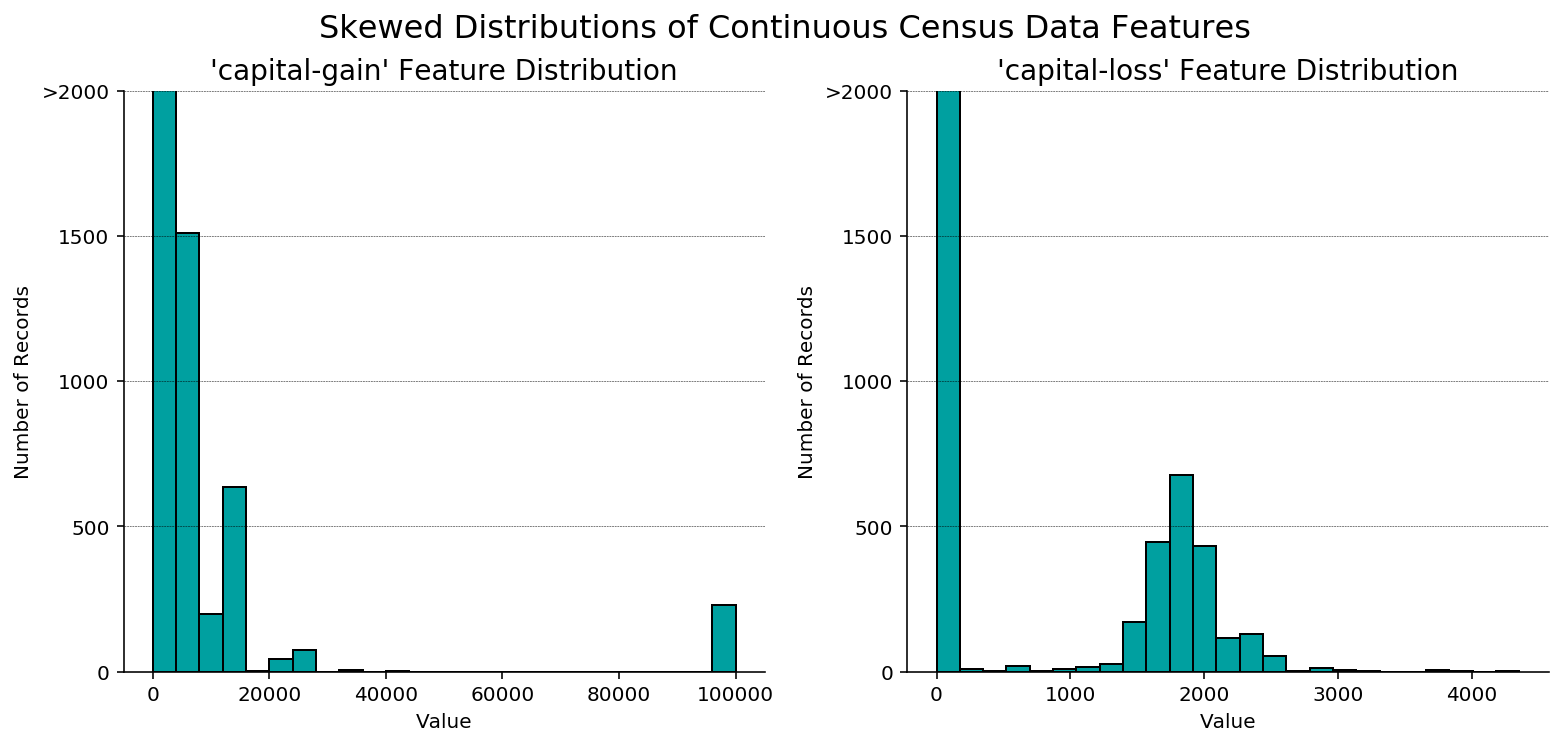

In [4]:
# Split the data into features and target label:
income_raw = data['income']
features_raw = data.drop('income', axis=1)

# Visualize skewed continuous features of original data:
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a [logarithmic transformation](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) on the data, so that the very large and very small values do not negatively affect the performance of a learning algorithm: Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

So, here, we are going to run the code cell below to perform a transformation on the data and visualize the results, and, again, we are going to note the range of values and how they are distributed. 

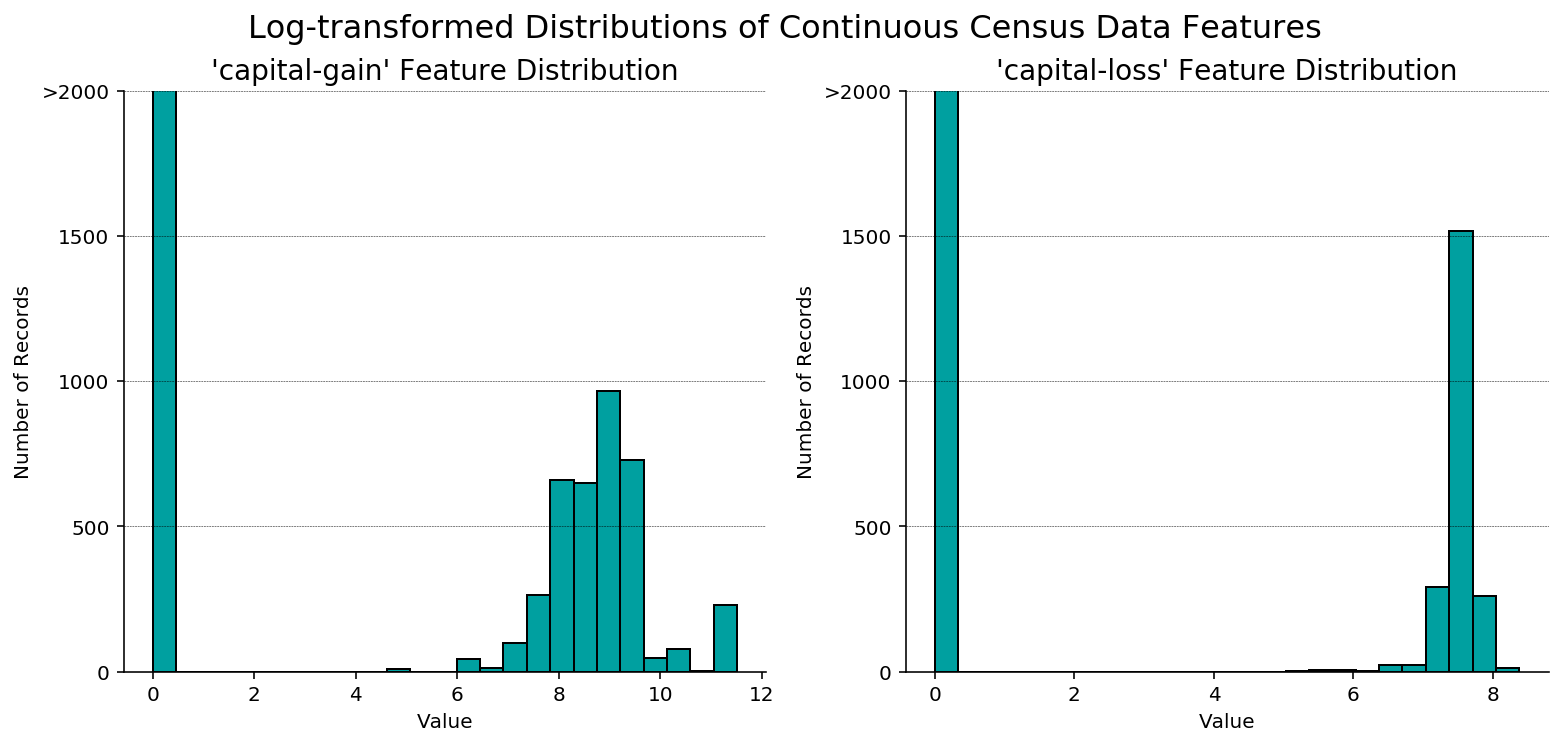

In [5]:
# Log-transform the skewed features:
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data=features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions:
vs.distribution(features_log_transformed, transformed=True)

### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data doesn't change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. We can note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Now, we are going to run the code cell below to normalize each numerical feature, and, for that, we will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [6]:
# Initialize a scaler and apply it to features:
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_log_minmax_transform = pd.DataFrame(data=features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied:
display(features_log_minmax_transform.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see that there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a *"dummy"* variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|  someFeature  |  someFeature_A  |  someFeature_B  |  someFeature_C  |
| ------------- | --------------- | --------------- | --------------- |
|  B            |      0          |       1         |         0       |
|  C            |      0          |       0         |         1       |
|  A            |      1          |       0         |         0       |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, we are going to implement the following:
- Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data
- Convert the target label `'income_raw'` to numerical entries, setting records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies():
dummy_fields = ['workclass',
                'education_level',
                'marital-status',
                'occupation',
                'relationship',
                'race',
                'sex',
                'native-country']
features_final = pd.get_dummies(features_log_minmax_transform, columns=dummy_fields)

# Encode the 'income_raw' data to numerical values:
income = income_raw.apply(lambda x: 0 if x == "<=50K" else 1)

# One-hot encoding results:
print("*** One-hot encoding results:\n")

# Print the number of features after one-hot encoding:
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.\n".format(len(encoded)))

# Print encoded feature names:
print("List of encoded feature names:")
for feature_name in encoded:
    print("- {}".format(feature_name))

*** One-hot encoding results:

103 total features after one-hot encoding.

List of encoded feature names:
- age
- education-num
- capital-gain
- capital-loss
- hours-per-week
- workclass_ Federal-gov
- workclass_ Local-gov
- workclass_ Private
- workclass_ Self-emp-inc
- workclass_ Self-emp-not-inc
- workclass_ State-gov
- workclass_ Without-pay
- education_level_ 10th
- education_level_ 11th
- education_level_ 12th
- education_level_ 1st-4th
- education_level_ 5th-6th
- education_level_ 7th-8th
- education_level_ 9th
- education_level_ Assoc-acdm
- education_level_ Assoc-voc
- education_level_ Bachelors
- education_level_ Doctorate
- education_level_ HS-grad
- education_level_ Masters
- education_level_ Preschool
- education_level_ Prof-school
- education_level_ Some-college
- marital-status_ Divorced
- marital-status_ Married-AF-spouse
- marital-status_ Married-civ-spouse
- marital-status_ Married-spouse-absent
- marital-status_ Never-married
- marital-status_ Separated
- marital-sta

### Shuffle and Split Data

Now, all *categorical variables* have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and testing sets: 80% of the data will be used for training and 20% for testing.

In [8]:
# Split the 'features' and 'income' data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(features_final,
                                                    income,
                                                    test_size=0.2,
                                                    random_state=42)

# Show the results of the split:
print("*** Results of the split:")
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

*** Results of the split:
Training set has 36177 samples.
Testing set has 9045 samples.


---

## Evaluating Model Performance

In this section, we will investigate four different algorithms, and determine which is the best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor

*CharityML*, equipped with their research, knows individuals that make more than USD 50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than USD 50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performance would be appropriate. Additionally, identifying someone that *does not* make more than USD 50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than USD 50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall}$$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the $F_{0.5}$ score (or **F-score** for simplicity).

Looking at the distribution of classes, those who make at most USD 50,000, and those who make more, it's clear most individuals do not make more than USD 50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than USD 50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for our data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than USD 50,000, *CharityML* would identify no one as donors. 

### Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

Now, to be more concrete, we can take as example a spam classifier, and follow with **precision** and **recall** definitions.

**Precision** tells us what proportion of messages we classified as spam, actually were spam. It is a ratio of true positives (mails classified as spam, and which are actually spam) to all positives (all mails classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of:

$$\frac{True Positives}{True Positives + False Positives}$$

**Recall (sensitivity)** tells us what proportion of mails that actually were spam were classified by us as spam. It is a ratio of true positives (mails classified as spam, and which are actually spam) to all the mails that were actually spam, in other words it is the ratio of:

$$\frac{True Positives}{True Positives + False Negatives}$$

For classification problems that are skewed in their classification distributions (like in our case), as for example the previous spam classifier, if we had 100 mails and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam (including the 2 that were spam but that we classify as not spam, hence they would be false negatives) and 10 as spam (all 10 false positives), and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average (harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score (we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performance

If we choose a model that always predicts an individual made more than USD 50,000, what would that model's accuracy and F-score be on the dataset? It's what we are going to note running the code cell below.

*Nota Bene:* The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally, our base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

When we have a model that always predicts '1' (i.e. the individual makes more than 50k), then, our model will have no True Negatives (TN) or False Negatives (FN) as we are not making any negative ('0' value) predictions. Therefore, our Accuracy in this case becomes the same as our Precision, $\frac{True Positives}{True Positives + False Positives}$, as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore, our denominator in this case is the total number of records we have.

*Nota Bene:* Our Recall score, $\frac{True Positives}{True Positives + False Negatives}$, in this setting becomes 1 as we have no False Negatives.

In [9]:
# Calculate accuracy, precision and recall:
tp_naive = np.sum(income)
fp_naive = income.count() - tp_naive
tn_naive = 0
fn_naive = 0
accuracy = (tp_naive + tn_naive)/(tp_naive + fp_naive + tn_naive + fn_naive)
precision = tp_naive/(tp_naive + fp_naive)
recall = tp_naive/(tp_naive + fn_naive)

# Calculate F-score using the formula above for beta = 0.5:
beta = 0.5
fscore = (1 + beta**2)*precision*recall/(beta**2*precision + recall)

# Print the results:
print("*** Results for Naive Predictor metrics:")
print("Accuracy: {:.4f}...".format(accuracy))
print("F-score: {:.4f}...".format(fscore))

*** Results for Naive Predictor metrics:
Accuracy: 0.2478...
F-score: 0.2917...


###  Supervised Learning Models

The following are some of the supervised learning models that are currently available in [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

From these models, we can choose **Random Forest**, **AdaBoost** and **Gradient Boosting** models, which are appropriate to our problem.

Here are some info on these models:
* **Random Forest:**
 * *Real-world application in industry:* A large array of classification problems, for example, in medecine, for [Lung Cancer Detection](https://arxiv.org/abs/1902.08236)
 * *Strengths:* Highly accurate and robust method, do not suffer overfitting problem
 * *Weaknesses:* Slow in generating predictions, difficult to interpret
 * *Why here?* Can be used for classification problems
 * *Reference:* [Understanding Random Forests Classifiers in Python](https://www.datacamp.com/community/tutorials/random-forests-classifier-python)
* **AdaBoost:**
 * *Real-world application in industry:* A large array of classification problems, for exemple, in business-related calculations and decision making, for [Improving Fault Prediction in Spreadsheets](https://arxiv.org/abs/1805.10493)
 * *Strengths:* Easy to understand, not prone to overfitting
 * *Weaknesses:* Sensitive to noise data
 * *Why here?* Can be used for classification problems
 * *Reference:* [AdaBoost Classifier in Python](https://www.datacamp.com/community/tutorials/adaboost-classifier-python)
* **Gradient Boosting:**
 * *Real-world application in industry:* A large array of classification problems, for example, in criminology, for [Forecasting Rare Violent Events](https://arxiv.org/abs/1903.00604)
 * *Strengths:* Speed and performance, consistently outperforms other algorithm methods, wide variety of tuning parameters
 * *Weaknesses:* Long training, need parameter training
 * *Why here?* Can be used for classification problems
 * *Reference:* [Using XGBoost in Python](https://www.datacamp.com/community/tutorials/xgboost-in-python)

### Creating a Training and Predicting Pipeline

To properly evaluate the performance of each model we have chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

Our implementation here will be used in the following section.

In the code block below, we are going to implement the following:
* Fit the learner to the sampled training data and record the training time.
* Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`, and record the total prediction time.
* Calculate the accuracy score for both the training and testing sets.
* Calculate the F-score for both the training and testing sets.

In [10]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    """
    Take in charge the training of a learner
    Inputs:
     learner: the learning algorithm to be trained and predicted on
     sample_size: the size of samples (number) to be drawn from training set
     X_train: features training set
     y_train: income training set
     X_test: features testing set
     y_test: income testing set
    Output:
     results: results of the learner's training
    """
    
    # Initialize results:
    results = {}
    
    # Fit learner to training data using slicing with 'sample_size':
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    # Calculate training time:
    results['train_time'] = end - start
        
    # Get predictions on testing set and first 300 training samples:
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    # Calculate prediction time:
    results['pred_time'] = end - start
            
    # Compute accuracy on first 300 training samples:
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on testing set:
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on first 300 training samples:
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Compute F-score on testing set:
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success:
    print("{} trained on {} samples...".format(learner.__class__.__name__, sample_size))
        
    # Return results:
    return results

### Initial Model Evaluation

In the next code cell, we are going to implement the following:
* Initialize the three models we have discussed in the previous section and store them in `'clf_A'`, `'clf_B'` and `'clf_C'` (*Nota Bene:* We will use the default settings for each model, and then tune one specific model in a later section).
* Calculate the number of records equal to 1%, 10%, and 100% of the training data, and store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'`, respectively.

*** Training results:
RandomForestClassifier trained on 361 samples...
RandomForestClassifier trained on 3617 samples...
RandomForestClassifier trained on 36177 samples...
AdaBoostClassifier trained on 361 samples...
AdaBoostClassifier trained on 3617 samples...
AdaBoostClassifier trained on 36177 samples...
GradientBoostingClassifier trained on 361 samples...
GradientBoostingClassifier trained on 3617 samples...
GradientBoostingClassifier trained on 36177 samples...


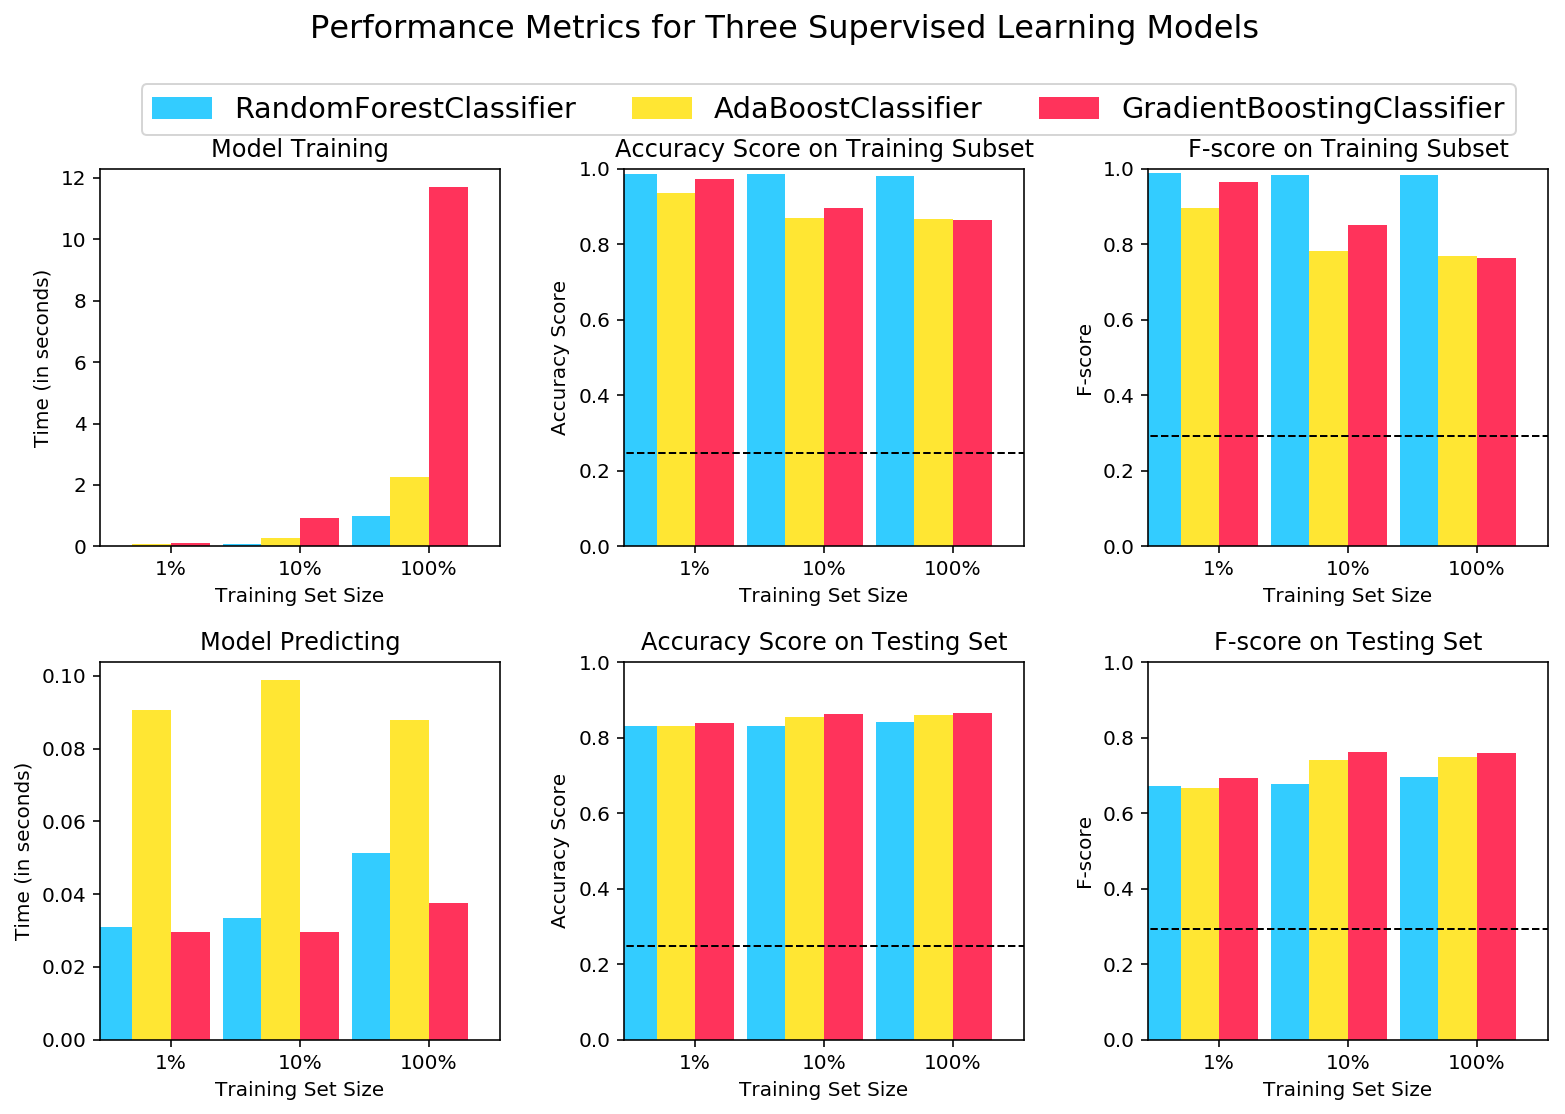

In [11]:
# Initialize the four models:
clf_A = RandomForestClassifier(random_state=42)
clf_B = AdaBoostClassifier(random_state=42)
clf_C = GradientBoostingClassifier(random_state=42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data:
samples_100 = len(y_train)
samples_10 = int(0.1*samples_100)
samples_1 = int(0.01*samples_100)

# Collect results on the learners:
print("*** Training results:")
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf,
                                             samples,
                                             X_train,
                                             y_train,
                                             X_test,
                                             y_test)

# Run metrics visualization for the four supervised learning models chosen:
vs.evaluate(results, accuracy, fscore)

---

## Improving Results

In this final section, we are going to choose from the three supervised learning models the *best* model to use on the dataset, and then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score.

### Choosing the Best Model

Based on the evaluation performed above, **Gradient Boosting Classifier** appears to be the most appropriate for identifying individuals that make strictly more than USD 50,000. Indeed:
* It is the one for which the F-score is the best with the entire testing dataset.
* It is the one for which the Accuracy is the best with the entire testing dataset.
* It is the fastest for making prediction on the entire testing dataset.
* With this one, no overfitting is observed, the metrics performance on training and testing datasets appear to be very close.

For all of these reasons, we are going to choose in the following the **Gradient Boosting Classifier**.

### Describing the Model in Layman's Terms

Gradient boosting consists on a collection of predictors (commonly called *weak learners*) aggregated together to produce a final model (commonly called *strong learner*) with which best performances can be obtained.

Each *weak learner* takes in charge and specialized itself on only certain portions of certain features, solving this way a small section of the problem we want to tackle.

After that, a focus is put on data points that are difficult to fit with the *weak learners*, and analyzing the errors and the influence of each feature or set of features, corrections are made with an iterative way, finally bringing us and producing a final model, the *strong learner*.

### Model Tuning

Now, we are going to fine tune this chosen model, using grid search.

In [12]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=42)

# Create the parameters list:
parameters = {"learning_rate": [0.1, 0.01, 0.001],
              "n_estimators": [100, 200, 300],
              "max_depth": [3, 4, 5]}

# Make a scorer:
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search:
grid_obj = GridSearchCV(clf, parameters, scorer)

# Fit the grid search:
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator:
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model:
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("*** Unoptimized Model:")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta=0.5)))
print("\n*** Optimized Model:")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

*** Unoptimized Model:
Accuracy score on testing data: 0.8638
F-score on testing data: 0.7580

*** Optimized Model:
Accuracy score on testing data: 0.8734
F-score on testing data: 0.7728


In [13]:
# Optimized parameters for the optimized model:
print("*** Optimized Model Parameters:")
print("Learning Rate: {}".format(best_clf.learning_rate))
print("Number of Estimators: {}".format(best_clf.n_estimators))
print("Maximum Depth: {}".format(best_clf.max_depth))

*** Optimized Model Parameters:
Learning Rate: 0.1
Number of Estimators: 200
Maximum Depth: 4


### Final Model Evaluation

The results we obtained can be summarized in the table below:

|     Metric     | Naive Model | Unoptimized Model | Optimized Model |
| -------------- | ----------- | ----------------- | --------------- | 
| Accuracy Score | 0.2478      | 0.8638            | 0.8734          |
| F-score        | 0.2917      | 0.7580            | 0.7728          |

---

## Feature Importance

An important task when performing supervised learning on a dataset - like the census data we study here - is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than USD 50,000.

### Feature Relevance Observation

When we explored the Data, it was shown there are thirteen available features for each individual on record in the census data. Before to check this aspect more precisely, we can try to guess the five features we believe to be the most important for prediction, ranking them and explaining why we choose them.
1. `education_level`: In a lot of companies or administrations, salary grids are applied, attributing the best salaries to the best diplomas, and, too, in our societies, the personns with the best education levels are, generally, the ones with the most lucratives jobs.
2. `occupation`: Occupation is, across all companies and administrations, a very standardized element, commonly associated to salary ranges, it's clearly an explicit indicador to predict a personn's income.
3. `hours-per-week`: Generally, the more someone works, the more money he earns: "Time is money", this feature is certainly very correlated to someone's income.
4. `age`: The older a professional is, the more skilled and valuated he generally is for a company or an administration, and, so, the more ambitious he can be in respect to his salary pretentions.
5. `workclass`: Being self-employed, or working for a private company or a public administration is generally not associated with the same incomes someone can pretend to earn.

### Extracting Feature Importance

Here, we are going to use the `feature_importance_` attribute of our previous classifier, which is a function that ranks the importance of features according to the chosen classifier.

In the code cell below, we are going to implement the following:
- Train our previous model on the entire training set.
- Extract the feature importances using `.feature_importances_`.

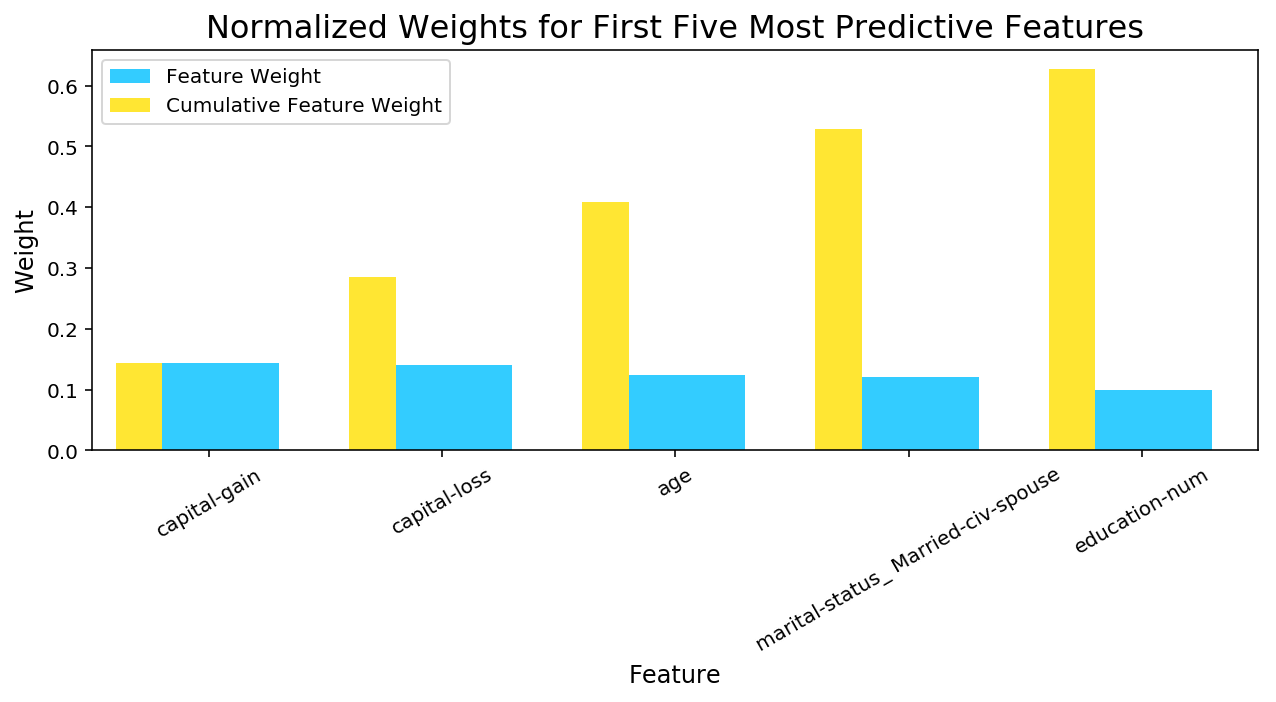

In [14]:
# Import a supervised learning model that has 'feature_importances_':
clf = GradientBoostingClassifier(random_state=42)

# Train the supervised model on the training set:
model = clf.fit(X_train, y_train)

# Extract the feature importances:
importances = model.feature_importances_

# Plot:
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

We can now take the time to observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above USD 50,000.  

Well, they are very different from the ones we have guessed previously!

Our only good appointement concerns the `age` feature.

`capital-gain`, `capital-loss` and `education-num` are features that we could have probably been able to guess, the situation is not the same for `marital-status_Married-civ-spouse`, but well, that is the case, at least for Gradient Boosting Classifier model!

### Feature Selection

How does a model perform if we only use a subset of all the available features in the data?

With less features required to train, the expectation is that training and prediction time is much lower, at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn.

In the code cell below, we will use the same optimized model we found earlier, and train it on the same training set *with only the top five important features*. 

In [15]:
# Reduce the feature space:
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier:
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions:
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data:
print("*** Final Model trained on full data:")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=0.5)))
print("\n*** Final Model trained on reduced data:")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta=0.5)))

*** Final Model trained on full data:
Accuracy on testing data: 0.8734
F-score on testing data: 0.7728

*** Final Model trained on reduced data:
Accuracy on testing data: 0.8601
F-score on testing data: 0.7452


### Effects of Feature Selection

Above, we can note that both Accuracy score and F-score have declined on reduced data comparatively to the scores on full data. Nevertheless, the observed diminution is not drastic (respectively 1% and 3% for Accuracy score and F-score), so, depending of some constraints (training time, performance scores), reduced data can be considered as a consistent option for training.